# Load Libraries

In [13]:
import warnings
warnings.filterwarnings("ignore")

import time
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sys import getsizeof
from collections import Counter

import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Load Data

In [14]:
# Load dataset 
data = pd.read_csv('dataset/smart_manufacturing_data.csv', parse_dates=['timestamp'])
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)
print('Original Labels:', Counter(data["anomaly_flag"].tolist()))

# Downsample data to get fewer anomalies
fraction_to_keep = 0.05
data_1 = data[data['anomaly_flag'] == 1].sample(frac=fraction_to_keep, random_state=42)
data_not_1 = data[data['anomaly_flag'] != 1]

# Combine and shuffle if needed
data = pd.concat([data_1, data_not_1]).reset_index(drop=True)
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)

print('Number of machines:', len(set(data['machine_id'].tolist())))
print('Updated Labels:', Counter(data["anomaly_flag"].tolist()))
data.head(5)

Original Labels: Counter({0: 91084, 1: 8916})
Number of machines: 50
Updated Labels: Counter({0: 91084, 1: 446})


,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 01:37:00,1,62.59,48.08,60.13,1.62,4.16,1,0,363,Normal,0.0,0
1,2025-01-01 01:42:00,1,70.88,68.67,50.57,1.05,2.36,1,0,111,Normal,0.0,0
2,2025-01-01 02:13:00,1,62.34,72.68,60.47,2.24,4.95,1,0,192,Normal,0.0,0
3,2025-01-01 02:19:00,1,88.03,53.36,50.79,3.08,2.25,1,0,301,Normal,0.0,0
4,2025-01-01 03:05:00,1,79.39,49.44,56.99,2.54,2.76,1,0,127,Normal,0.0,0


# Modeling

In [15]:
# Scale and split features
# Split by machines
machine_train = list(range(1, 41)) # 1-40
machine_test = list(range(41, 51)) # 41-50

features = ["temperature", "vibration", "humidity", "pressure", "energy_consumption"]

X_train = data[data['machine_id'].isin(machine_train)][features]
X_test = data[data['machine_id'].isin(machine_test)][features]

y_train = data[data['machine_id'].isin(machine_train)]['anomaly_flag']
y_test = data[data['machine_id'].isin(machine_test)]['anomaly_flag']

print('Train:', len(y_train))
print('Test :', len(y_test))

print('Train:', Counter(y_train))
print('Test :', Counter(y_test))

Train: 73349
Test : 18181
Train: Counter({0: 73001, 1: 348})
Test : Counter({0: 18083, 1: 98})


In [16]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Weight: 2097.729885057471
[LightGBM] [Info] Number of positive: 279, number of negative: 58400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 58679, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004755 -> initscore=-5.343859
[LightGBM] [Info] Start training from score -5.343859
[LightGBM] [Info] Number of positive: 278, number of negative: 58401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 58679, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004738 -> in

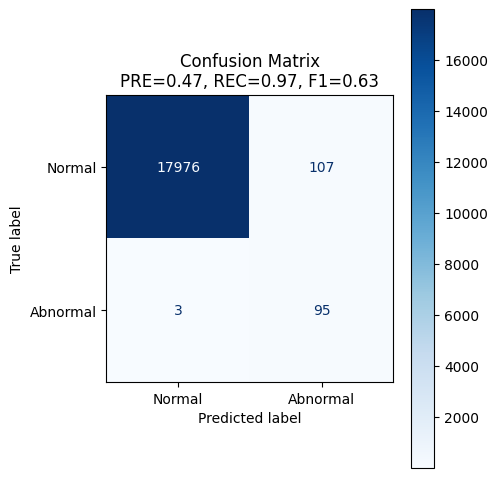

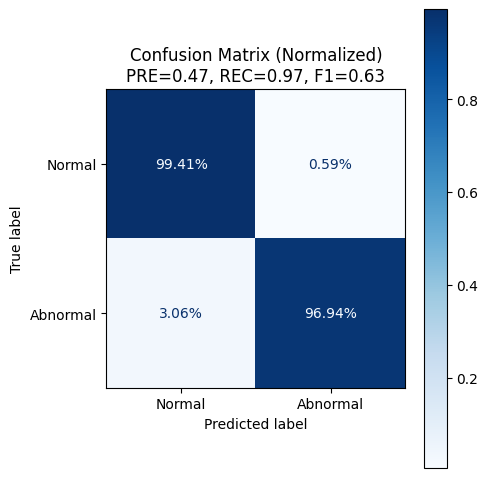

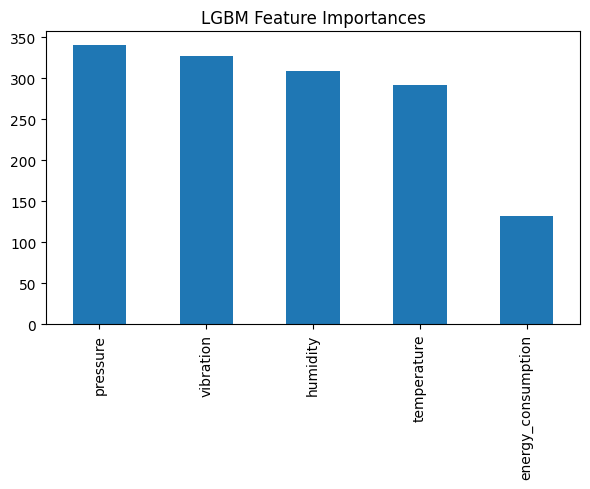

In [17]:

# Train LightGBM binary classifier
pos_weight = (y_train == 0).sum() / (y_train == 1).sum() * 10
print('Weight:', pos_weight)

param_grid = {
    'num_leaves': [15, 30],
    'learning_rate': [0.01, 0.1],
}

model = lgb.LGBMClassifier(scale_pos_weight=pos_weight)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
clf.fit(X_train, y_train)

best_params = clf.best_params_
print("Best hyperparameters:", best_params)

y_pred = clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print("Classification Report:\n", classification_report(y_test, y_pred))

results = f'PRE={prec:.2f}, REC={rec:.2f}, F1={f1:.2f}'
print(results)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Confusion Matrix\n{results}")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_cm.png')
plt.show()

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2%')
plt.title(f"Confusion Matrix (Normalized)\n{results}")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_cm_normalized.png')
plt.show()

# Feature importance
importances = clf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(6, 5))
plt.title("LGBM Feature Importances")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_feature_importance.png')
plt.show()

# Saving model
with open('models/model_lgbm.pkl', 'wb') as f:
    pickle.dump(clf, f)

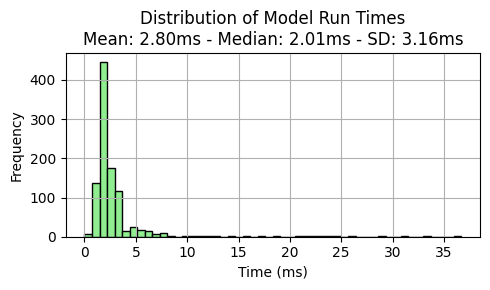

In [18]:
# Testing model speed
list_compute_time = []

for X_sample in X_test[:1000]:
    start = time.time()
    y_pred = clf.predict([X_sample])
    end = time.time()
    compute_time = end-start
    list_compute_time.append(compute_time)

list_compute_time = [x*1e3 for x in list_compute_time]

mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
results = f"Mean: {mean_time:.2f}ms - Median: {median_time:.2f}ms - SD: {std_dev_time:.2f}ms"

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(list_compute_time, bins=50, edgecolor='black', color='lightgreen')
plt.title(f'Distribution of Model Run Times\n{results}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_run_time.png')
plt.show()

# Modelling (Optimize)

In [19]:
# Scale and split features
# Split by machines
machine_train = list(range(1, 41)) # 1-40
machine_test = list(range(41, 51)) # 41-50

features = ["temperature", "vibration", "humidity", "pressure"] # "energy_consumption"

X_train = data[data['machine_id'].isin(machine_train)][features]
X_test = data[data['machine_id'].isin(machine_test)][features]

y_train = data[data['machine_id'].isin(machine_train)]['anomaly_flag']
y_test = data[data['machine_id'].isin(machine_test)]['anomaly_flag']

print('Train:', len(y_train))
print('Test :', len(y_test))

print('Train:', Counter(y_train))
print('Test :', Counter(y_test))

Train: 73349
Test : 18181
Train: Counter({0: 73001, 1: 348})
Test : Counter({0: 18083, 1: 98})


In [20]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Weight: 2097.729885057471
[LightGBM] [Info] Number of positive: 279, number of negative: 58400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 58679, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004755 -> initscore=-5.343859
[LightGBM] [Info] Start training from score -5.343859
[LightGBM] [Info] Number of positive: 278, number of negative: 58401
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 58679, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004738 -> in

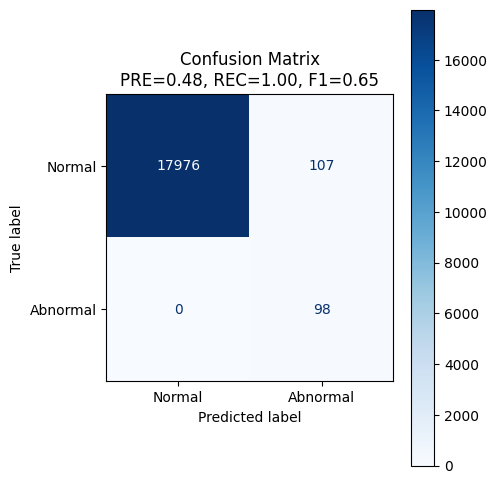

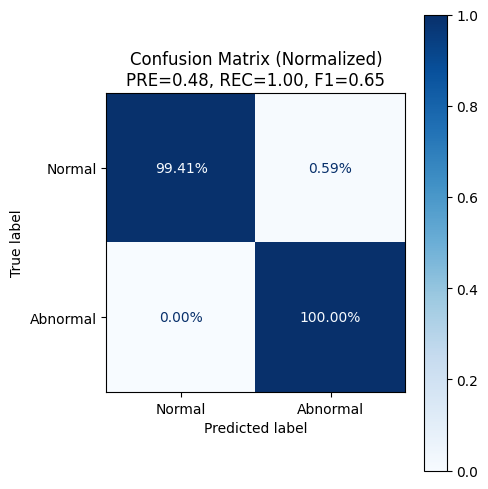

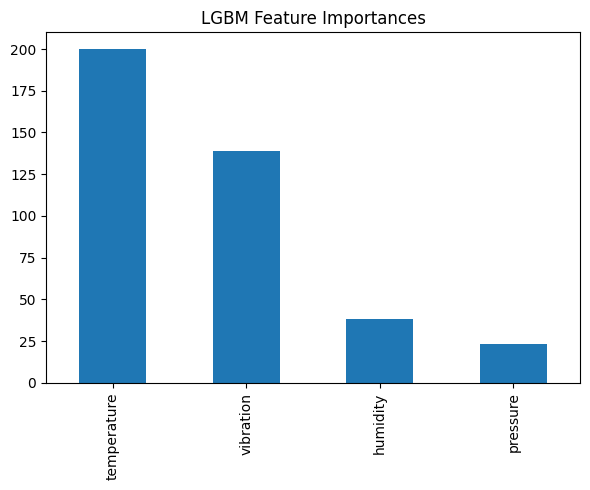

In [21]:
# Train LightGBM binary classifier
pos_weight = (y_train == 0).sum() / (y_train == 1).sum() * 10
print('Weight:', pos_weight)

param_grid = {
    'num_leaves': [5, 10],
    'learning_rate': [0.01, 0.1],
}

model = lgb.LGBMClassifier(scale_pos_weight=pos_weight)
clf = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
clf.fit(X_train, y_train)

best_params = clf.best_params_
print("Best hyperparameters:", best_params)

y_pred = clf.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print("Classification Report:\n", classification_report(y_test, y_pred))

results = f'PRE={prec:.2f}, REC={rec:.2f}, F1={f1:.2f}'
print(results)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title(f"Confusion Matrix\n{results}")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_s_cm.png')
plt.show()

# Normalize by true labels (rows)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Normal', 'Abnormal'])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2%')
plt.title(f"Confusion Matrix (Normalized)\n{results}")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_s_cm_normalized.png')
plt.show()

# Feature importance
importances = clf.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(6, 5))
plt.title("LGBM Feature Importances")
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_s_feature_importance.png')
plt.show()

# Saving model
with open('models/model_lgbm.pkl', 'wb') as f:
    pickle.dump(clf, f)

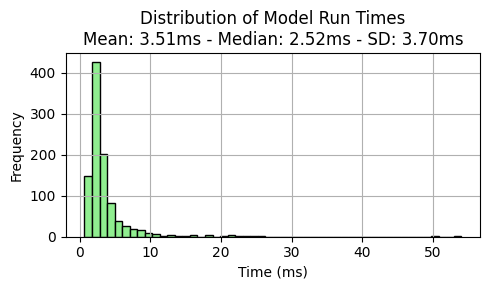

In [22]:
list_compute_time_org = list_compute_time.copy()

# Testing model speed
list_compute_time = []

for X_sample in X_test[:1000]:
    start = time.time()
    y_pred = clf.predict([X_sample])
    end = time.time()
    compute_time = end-start
    list_compute_time.append(compute_time)

list_compute_time = [x*1e3 for x in list_compute_time]

mean_time = np.mean(list_compute_time)
median_time = np.median(list_compute_time)
std_dev_time = np.std(list_compute_time)

# Display the results
results = f"Mean: {mean_time:.2f}ms - Median: {median_time:.2f}ms - SD: {std_dev_time:.2f}ms"

# Plotting the histogram
plt.figure(figsize=(5, 3))
plt.hist(list_compute_time, bins=50, edgecolor='black', color='lightgreen')
plt.title(f'Distribution of Model Run Times\n{results}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.savefig('results/lgbm/lgbm_s_run_time.png')
plt.show()

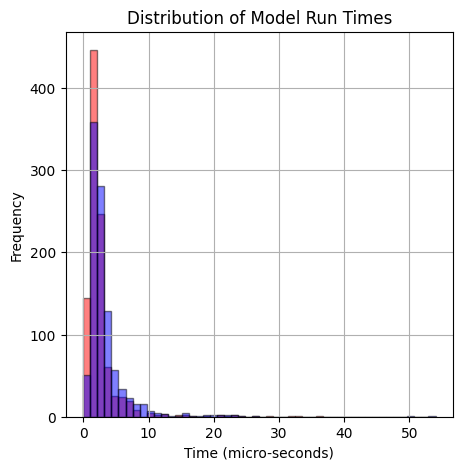

In [23]:
# Plotting the histogram
plt.figure(figsize=(5, 5))
bins = np.histogram_bin_edges(np.concatenate([list_compute_time_org, list_compute_time]), bins=50)
plt.hist(list_compute_time_org, bins=bins, edgecolor='black', color='red', alpha=0.5, label='Original')
plt.hist(list_compute_time, bins=bins, edgecolor='black', color='blue', alpha=0.5, label='Optimized')
plt.title('Distribution of Model Run Times')
plt.xlabel('Time (micro-seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('results/lgbm/lgbm_compare_run_time.png')
plt.show()